# Exercise 4

In this exercise, you will understand and implement the below concepts :

*   Reading a text dataset.
*   Pre-processing the text such as Stopwords Removal etc.
*   Word embedding 
    1.   Vocabulary Indexing
    2.   Glove embedding
*   Implementing Dataloaders
*   A Neural Network
    1.   RNNs
    2.   LSTMs
*   Evaluation of the network


The task here is to develop a simple sentiment analysis model for a dataset by understanding if the review is positive or negative for each statement.

# Task 1 : A simple Sentiment Analysis model

In [ ]:
import torch
from torchtext import data
from torchtext import datasets
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
import re
import nltk
nltk.download('punkt')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import collections
from collections import Counter

from string import punctuation
stop_words = set(stopwords.words('english'))

# Read the input CSV file

Write a function to read the text data with the review text as features and the sentiment (1 for positive and 0 for negative) as labels.


In [ ]:
def read_file(file_name):
  """
      file_name: The name of the CSV Input data file "SJ_Unsupervised_NLP_data.txt"
        
      return the features and labels
  """
  ######################################
  ######### YOUR CODE HERE #############
  ######################################

  with open(file_name, 'r') as f:
    data = f.read()

  # Splitting the data to make list of reviews and labels
  data = [i.split('\t') for i in data.split('\n')]

  # Removing last blank element
  if len(data[-1])==1:
    data.pop(-1)

  train_x = [i[0] for i in data]
  train_y1 = [i[1] for i in data]

  # Changing datatype of list from string to int

  train_y = [int(i) for i in train_y1]
  
  return train_x, train_y

# Pre-process the sentences

*   For example, remove the stopwords, special characters and so on. 
*   The most important step here is to tokenize the sentences. 

Expect that the accuracy would be more if your dataset is well pre-processed.

In [ ]:
def preprocess_text(inputtext, tokenize=True):

    """
      text: The review text.
        
      return: Tokenized pre-processed text if Tokenize=true, else just the pre-processed text.
    """
    ######################################
    ######### YOUR CODE HERE #############
    ######################################

    text = np.array([])
    for line in inputtext:
      line = line.lower()  #  Converted all to lower-case
      unpunctuated = ''.join([ch for ch in line if ch not in punctuation])  # All punctuations removed
      stopwords_removed = ' '.join([word for word in unpunctuated.split() if word not in stop_words])  # All stopwords removed
      text = np.append(text, stopwords_removed)

    if tokenize:
      text1 = []
      for line in text:
        tokanized_line = word_tokenize(line)
        text1.append(tokanized_line)
        
      text = text1

    return text

# Building the vocabulary

 

*   Count the number of occurances of all the words from all of the reviews by using a Counter function.
*   Sort the words in descending order.
*   Print the 10 more frequently occuring words (just to cross verify with the dataset).

 


In [ ]:
def count_words(all_reviews):
  """
      all_reviews: all the review sentences which are tokenized.
        
      return: The list of words based on the decreasing order of their occurances. Also return the length of the list. Sample given below.
  """

  ######################################
  ######### YOUR CODE HERE #############
  ######################################

  text1=[]
  for sentence in all_reviews:
    for word in sentence:
      text1.append(word)

  counts = Counter(text1)    # get the count of occurences of individual words

  words_list = sorted(counts, key=counts.get, reverse=True)     # Sort the words in descending order of their occurences

  print('The 10 more frequently occuring words are: ', words_list[:10])

  return words_list, len(words_list)

# Embedding the words

*   Encode the reviews in number format based on the index of the word in the vocabulary. Build a function word2idx_embedding from scratch such that for each review containing list of tokens(words), a numbered vector of it's corresponding positions in the vocabulary is returned. 

Note : Word-to-index is a variant of the one-hot-encoding where instead of filling 0's and 1's throughout the vocabulary for each word present in the review, we replace the review words by it's corresponding index value from the vocabulary. This drastically reduces the run-time. 

Make sure you add +1 since the index of the vocab starts from 0, and we want the word positions from 1.



In [ ]:
def word2idx_embedding(words_list, reviews_in_words):
    """
        words_list: list of all words in the vocabulary sorted in descending order
        reviews_in_words: All the reviews tokenized as words
        
        return a list of vocab_to_int or the word2idx (the dictionary of words and it's integer positions) 
        and also the list of vectors which are encoded by word2idx for all reviews
    """
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    #words_list = tuple(words_list)

    vocab_to_int = {value: index for index,value in enumerate(words_list, start=1)}

    emdedded_vector_list = []
    for review in reviews_in_words:
        emdedded_vector_list.append([vocab_to_int[word] for word in review])

    return vocab_to_int, emdedded_vector_list

*   Pad the embedded vector of each review to bring up a unified vector length defined by the sequence length.


In [ ]:
def pad_text(encoded_reviews):
  """
        encoded_reviews: list of embedded vectors which are yet to be padded.
        
        return the numpy array of vectors
    """
  seq_length = 20

  ######################################
  ######### YOUR CODE HERE #############
  ######################################

  padded_reviews = np.zeros((len(encoded_reviews), seq_length), dtype=int)

  for id, rev in enumerate(encoded_reviews):
      padded_reviews[id, :len(rev)] = np.array(rev)[:seq_length] 

  
  return np.array(padded_reviews)

# Build dataloaders

*   Split the train, validation and test as 80/10/10 respectively.
*   Create the data loaders using the TensorDataset function with a batch size of 20.



In [ ]:
def get_loaders(data, labels, batch_size):

  """
      return the train, validation and test set loaders
  """

  ######################################
  ######### YOUR CODE HERE #############
  ######################################

  # Splitting the Data
  data = np.array(data)
  labels = np.array(labels)
  
  train_split = 0.8
  split_idx = int( len(data)* train_split )

  train_x, remaining_x = data[:split_idx], data[split_idx:]
  train_y, remaining_y = labels[:split_idx], labels[split_idx:]

  val_split = len(remaining_x)//2

  val_x, test_x = remaining_x[:val_split], remaining_x[val_split:]
  val_y, test_y = remaining_y[:val_split], remaining_y[val_split:]

  
  # Create Tensor Dataset
  train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
  val_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
  test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

  # Creating Dataloaders
  tr_loader = DataLoader(train_data, batch_size= batch_size, shuffle=True)
  v_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
  t_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

  return tr_loader, v_loader, t_loader

# Build your model

*   Build a simple RNN architecture model based on the below visualization.
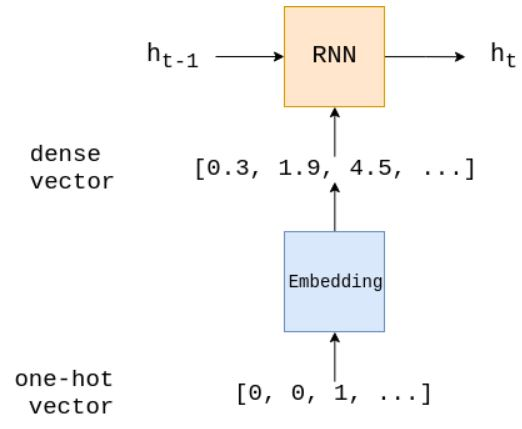

However, instead of the 'one-hot-vector', we use the 'padded word2idx Embedding' variant as input here.


In [ ]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
import torch.nn as nn

class Sentiment_RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        ######################################
        ######### YOUR CODE HERE #############
        ######################################
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True) 
        self.dropout = nn.Dropout(0.8)   
        self.fc = nn.Linear(hidden_dim, output_dim)

        
    def forward(self, text):

        ######################################
        ######### YOUR CODE HERE #############
        ######################################
        
        embedded = self.embedding(text)

        output, hidden = self.rnn(embedded)

        hidden = self.dropout(hidden)

        op1 = self.fc(hidden.squeeze(0))
        
        return op1
        




*   Initialize your model


In [ ]:
def init_model(vocab_size):

  input_dim = vocab_size + 1  #Note that since we have added a zero padding, we need to add +1 here.
  output_dim = 1
  embedding_dim = 100
  hidden_dim = 256

  model = Sentiment_RNN(input_dim, embedding_dim, hidden_dim, output_dim)
  model.to(device)

  criterion = nn.BCEWithLogitsLoss()
  #optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.00003)

  return model, criterion, optimizer

*   Define an accuracy function that will round off the predictions to the nearest integer and checks the accuracy by comparing it with the true label.


In [ ]:
def binary_accuracy(preds, y):
    """
    Returns the accuracy activating the prediction using the 'sigmoid' function and tounding off to the closest integer. 
    Compare the rounded_prediction with the true label.
    """

    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    
    #sig = nn.Sigmoid()
    preds = torch.sigmoid(preds)
    preds = torch.round(preds)
    acc = torch.sum(torch.eq(preds,y))/preds.nelement()

    return acc

# Train your model

*   Compute the loss and binary accuracy.
*   Average the total loss and accuracy over the 'train_loader' size. 



In [ ]:
def train_model(model, criterion, optimizer, train_loader):
  
  model.train()

  epoch_loss = 0
  epoch_acc = 0

  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    ######################################
    ######### YOUR CODE HERE #############
    ######################################

    optimizer.zero_grad()
    predictions = (model(inputs)).squeeze(1)  # Squeeze the model o/p to make predictions shape equals labels shape
    loss = criterion(predictions.type(torch.FloatTensor), labels.type(torch.FloatTensor))

    acc = binary_accuracy(predictions, labels)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  train_loss =  epoch_loss / len(train_loader)
  train_acc = epoch_acc / len(train_loader)  
  return train_loss, train_acc



# Evaluate your model 

*   Similar to training process but no back propogation or optimization.
*   Average the total loss and accuracy over the 'loader' size

In [ ]:
def evaluate_model(model, criterion, loader):
  epoch_loss = 0
  epoch_acc = 0
    
  model.eval()
    
  with torch.no_grad():
    
    for inputs, labels in loader:
      inputs, labels = inputs.to(device), labels.to(device)

      ######################################
      ######### YOUR CODE HERE #############
      ######################################

      predictions = (model(inputs)).squeeze(1)  # Squeeze the model o/p to make predictions shape equals labels shape
      loss = criterion(predictions.type(torch.FloatTensor), labels.type(torch.FloatTensor))

      acc = binary_accuracy(predictions, labels)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
        
  loss =  epoch_loss / len(loader)
  #print(f'epoch loss---------{loss}')
  acc = epoch_acc / len(loader) 
  #print(f'epoch acc---------{acc}') 
  return loss, acc

# Run your sentiment analysis engine

*   Run the below code after implementing all the functions to find the accuracy of the test set using the model.


In [ ]:
batch_size = 20
NUM_EPOCHS = 5

train_x, train_y = read_file("SJ_Unsupervised_NLP_data.txt")
tokenized_preprocessed_reviews = preprocess_text(train_x)
#tokenized_preprocessed_reviews = [preprocess_text(x) for x in train_x]
words_list, vocab_size = count_words(tokenized_preprocessed_reviews)
vocab_to_int, emdedded_vector_list = word2idx_embedding(words_list, tokenized_preprocessed_reviews)
final_data = pad_text(emdedded_vector_list)
final_labels = np.array(train_y)

# #Building, training and evaluating your model
tr_loader, v_loader, t_loader = get_loaders(final_data, final_labels, batch_size)
model, criterion, optimizer = init_model(vocab_size)

for epoch in range(NUM_EPOCHS):

  train_loss, train_acc = train_model(model, criterion, optimizer, tr_loader)
  valid_loss, valid_acc = evaluate_model(model, criterion, v_loader)

  print(f'Epoch: {epoch+1:02}')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

# #Evaluate the test accuracy
test_loss, test_acc = evaluate_model(model, criterion, t_loader)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
test_acc_using_RNN = test_acc*100

The 10 more frequently occuring words are:  ['phone', 'great', 'good', 'product', 'quality', 'headset', 'works', 'battery', 'sound', 'use']
Epoch: 01
	Train Loss: 0.731 | Train Acc: 49.38%
	 Val. Loss: 0.693 |  Val. Acc: 46.00%
Epoch: 02
	Train Loss: 0.704 | Train Acc: 51.00%
	 Val. Loss: 0.694 |  Val. Acc: 49.00%
Epoch: 03
	Train Loss: 0.706 | Train Acc: 52.13%
	 Val. Loss: 0.694 |  Val. Acc: 49.00%
Epoch: 04
	Train Loss: 0.712 | Train Acc: 49.75%
	 Val. Loss: 0.694 |  Val. Acc: 49.00%
Epoch: 05
	Train Loss: 0.721 | Train Acc: 48.00%
	 Val. Loss: 0.694 |  Val. Acc: 49.00%
Test Loss: 0.697 | Test Acc: 42.00%


# Task 2: Replace 'word2idx' with the pre-trained glove embedding

*   Let us build our own Glove embeding vector file using the Word2Vec function from gensim.



In [ ]:
from gensim.models import Word2Vec



*   Pre-process the sentence as before by calling the preprocess_text function'
*   Call the Word2Vec function to create the custom glove embedding using Skip-gram method and set the embedding dimension as 100. Also set the minimum count of the word to be 1. 
*   Save the file.



In [ ]:
def preprocess_and_save_glove(data):

  ######################################
  ######### YOUR CODE HERE #############
  ######################################

  preprocessed_data = preprocess_text(data)
  model_w2v = Word2Vec(sentences=preprocessed_data, min_count=1, size=100, sg=1)
  model_w2v.wv.save_word2vec_format('custom_glove_100d.txt')





*   Let us read this 'glove' vector and create a word_to_vector map.

For example, an entry in the map looks like:

'small': array([-0.00258583, -0.0002086 ,  0.00410562, -0.0002388,....])

where 'small' is a word in the glove vector file with it's corresponding embedding vector of 100 dimensions.



In [ ]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)

  return word_to_vec_map


*   Create an embedding matrix of size (vocab_size * embedding_size) and fill the corresponding embedding values from the word_to_vec map for each word of the vocabulary.



In [ ]:
def create_embedding_matrix(vocab_size, embed_size, word_to_vec_map, vocab_to_int):
  emb_matrix = np.zeros((vocab_size+1, embed_size))

  ######################################
  ######### YOUR CODE HERE #############
  ######################################

  # Filling the embedding values in the matrix for corresponding words
  for i in vocab_to_int:
    emb_matrix[vocab_to_int[i]] = word_to_vec_map[i]
    
  return torch.from_numpy(emb_matrix)

In [ ]:
embed_size = 100

preprocess_and_save_glove(train_x)
word_to_vec_map = read_glove_vector('custom_glove_100d.txt')
embedding_matrix = create_embedding_matrix(vocab_size, embed_size, word_to_vec_map, vocab_to_int) #vocab_size and vocab_to_int got from the previous task

# Task 3: Replacing RNNs with LSTMs

*   After replacing the 'word2idx' embedding to the 'glove' embedding, we shall replace our simple RNN to an LSTM and see if it impacts the accuracy
*   Only the model building code changes. However, the training and valiation function remains the same.

In [ ]:
import torch.nn as nn

class Sentiment_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        super().__init__()


        self.output_dim = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=dropout, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    
    def forward(self, x,hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        out = out.view(batch_size, -1)
        out = out[:, -1]
        
        return out, hidden


    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (device.type == 'cuda'):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

        



*   While initiating our model, we have to perform one additional step of copying the weights of the embedding layer computed in the previous step using the glove embedding (which is the embedding matrix). Hence, we don't need to additionally learn the embedding weights since it is now replaced by the pre-trained embeddings.



In [ ]:
def init_LSTM_model(vocab_size):

  input_dim = vocab_size + 1  #Note that since we have added a zero padding, we need to add +1 here.
  output_dim = 1
  embedding_dim = 100
  hidden_dim = 256
  n_layers = 2
  bidirectional = True
  dropout = 0.5

  model = Sentiment_LSTM(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout)
  model.to(device)

  ######################################
  ######### YOUR CODE HERE #############
  ######################################
  model.embedding.from_pretrained(embedding_matrix)

  criterion = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  return model, criterion, optimizer



*   Run the below code after implementing all the functions to find the accuracy of the test set using the model.



In [ ]:
def train_model_lstm(model, criterion, optimizer, train_loader, h):
  
  model.train()

  epoch_loss = 0
  epoch_acc = 0

  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    ######################################
    ######### YOUR CODE HERE #############
    ######################################

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    optimizer.zero_grad()
    output, h = model(inputs, h)  # Squeeze the model o/p to make predictions shape equals labels shape
   
    loss = criterion(output.squeeze(), labels.float())

    acc = binary_accuracy(output, labels)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  train_loss =  epoch_loss / len(train_loader)
  train_acc = epoch_acc / len(train_loader)  
  return train_loss, train_acc

In [ ]:
def evaluate_model_lstm(model, criterion, loader, h):
  epoch_loss = 0
  epoch_acc = 0
    
  model.eval()
    
  with torch.no_grad():
    
    for inputs, labels in loader:
      inputs, labels = inputs.to(device), labels.to(device)

      ######################################
      ######### YOUR CODE HERE #############
      ######################################

      h = tuple([each.data for each in h])

      output, h = model(inputs, h)  # Squeeze the model o/p to make predictions shape equals labels shape
      loss = criterion(output.squeeze(), labels.float())

      acc = binary_accuracy(output, labels)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
        
  loss =  epoch_loss / len(loader)
  acc = epoch_acc / len(loader) 
 
  return loss, acc

In [ ]:
NUM_EPOCHS = 20



model, criterion, optimizer = init_LSTM_model(vocab_size)

for epoch in range(NUM_EPOCHS):

  h = model.init_hidden(batch_size)

  train_loss, train_acc = train_model_lstm(model, criterion, optimizer, tr_loader, h)
  valid_loss, valid_acc = evaluate_model_lstm(model, criterion, v_loader, h)

  print(f'Epoch: {epoch+1:02}')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

# #Evaluate the test accuracy
test_loss, test_acc = evaluate_model_lstm(model, criterion, t_loader, h)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
test_acc_using_LSTM = test_acc*100

Epoch: 01
	Train Loss: 0.699 | Train Acc: 52.13%
	 Val. Loss: 0.695 |  Val. Acc: 49.00%
Epoch: 02
	Train Loss: 0.694 | Train Acc: 51.13%
	 Val. Loss: 0.693 |  Val. Acc: 49.00%
Epoch: 03
	Train Loss: 0.695 | Train Acc: 50.50%
	 Val. Loss: 0.693 |  Val. Acc: 51.00%
Epoch: 04
	Train Loss: 0.696 | Train Acc: 48.75%
	 Val. Loss: 0.693 |  Val. Acc: 51.00%
Epoch: 05
	Train Loss: 0.695 | Train Acc: 48.25%
	 Val. Loss: 0.696 |  Val. Acc: 49.00%
Epoch: 06
	Train Loss: 0.694 | Train Acc: 51.00%
	 Val. Loss: 0.694 |  Val. Acc: 49.00%
Epoch: 07
	Train Loss: 0.694 | Train Acc: 49.38%
	 Val. Loss: 0.694 |  Val. Acc: 49.00%
Epoch: 08
	Train Loss: 0.693 | Train Acc: 51.00%
	 Val. Loss: 0.694 |  Val. Acc: 49.00%
Epoch: 09
	Train Loss: 0.693 | Train Acc: 50.00%
	 Val. Loss: 0.693 |  Val. Acc: 49.00%
Epoch: 10
	Train Loss: 0.694 | Train Acc: 48.25%
	 Val. Loss: 0.694 |  Val. Acc: 49.00%
Epoch: 11
	Train Loss: 0.694 | Train Acc: 49.63%
	 Val. Loss: 0.693 |  Val. Acc: 49.00%
Epoch: 12
	Train Loss: 0.672 | T

In [ ]:
print(f'The test accuracy using the RNNs is: {test_acc_using_RNN}%')
print(f'The test accuracy using the LSTMs is: {test_acc_using_LSTM}%')

The test accuracy using the RNNs is: 42.00000047683716%
The test accuracy using the LSTMs is: 65.00000238418579%


# Task 4: Optional task for learning

*   Now that you have a good understanding about pre-processing the text, perform a much stringent pre-processing removing the nouns, verbs and adjectives, and find out the accuracy for each part-of-speech removal



In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True



*   Also, create a map with 'noun', 'verb' and 'adjective' as the key and it's corresponding reviews as the values. 

In [ ]:
def remove_pos_from_reviews(reviews):

  all_reviews_without_nouns = []
  all_reviews_without_verbs = []
  all_reviews_without_adjectives = []

  all_review_maps = {}
  ######################################
  ######### YOUR CODE HERE #############
  ######################################

  return all_review_maps #Containing all the reviews of the noun, verb and adjective void text

# Build the model engine

*   Looking at the previous sections (Refer to : Run your sentiment analysis engine), build the engine that will create the dataloaders, build-train-evaluate the models.
*   Loop through each element in 'all_review_maps' to calculate the accuracy of each Part-of-speech removal. Print the accuracies for Noun, Verb, Adjectives.



In [ ]:
batch_size = 20
NUM_EPOCHS = 5

######################################
######### YOUR CODE HERE #############
######################################